<a href="https://colab.research.google.com/github/AlexAve8/BA_Eigenwertverfahren_2026/blob/main/BA_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from itertools import product
from scipy.optimize import brentq
from scipy.linalg import hessenberg
import matplotlib.pyplot as plt

np.random.seed(42)

In [ ]:
def QR_via_KGS(A_in):
    A = A_in.astype(np.float64).copy()
    m, n = A.shape
    Q = np.zeros((m, n), dtype=np.float64)
    R = np.zeros((n, n), dtype=np.float64)
    A_cols = [A[:, i] for i in range(n)]
    for i in range(n):
        for j in range(i):
            R[j, i] = Q[:, j] @ A_cols[i]
        v_i = A_cols[i].copy()
        for j in range(i):
            v_i -= R[j, i] * Q[:, j]
        r_ii = np.linalg.norm(v_i)
        R[i, i] = r_ii
        # Voller Rang angenommen: r_ii sollte nicht Null sein.
        Q[:, i] = v_i / r_ii
    return Q, R

def QR_via_MGS(A_in):
    A = A_in.astype(np.float64).copy()
    n,m = A.shape
    rank = np.linalg.matrix_rank(A)

    Q = np.zeros((n, n), dtype=np.float64)
    R = np.zeros((n, n), dtype=np.float64)
    for i in range(n):
        norm_a_i = np.linalg.norm(A[:, i])
        R[i,i] = norm_a_i
        Q[:,i] = A[:,i] / norm_a_i
        for j in range(i+1,n):
            R[i,j] = Q[:,i] @ A[:,j]
            A[:,j] -= R[i,j] * Q[:,i]
    return Q,R

In [ ]:
def solve_secular(d, z, rho):
    n = len(d)
    roots = np.zeros(n)

    delta = 1e-12

    # Summe von z^2 vorberechnen (für die Bounds)
    z_sq_sum = np.sum(z**2)

    for i in range(n):
        # Initialisierung mit ungültigen Werten
        lower, upper = 0.0, 0.0

        # --- GRENZEN DEFINIEREN ---
        if rho > 0:
            # Fall A: Wurzeln liegen rechts von d[i]
            lower = d[i] + delta

            if i < n - 1:
                upper = d[i+1] - delta
            else:
                # Letzter Eigenwert rechts außen
                upper = d[i] + rho * z_sq_sum + 2.0 * np.linalg.norm(d, np.inf)

        else: # rho < 0
            # Fall B: Wurzeln liegen links von d[i]
            upper = d[i] - delta

            if i > 0:
                lower = d[i-1] + delta
            else:
                # Erster Eigenwert links außen
                lower = d[i] + rho * z_sq_sum - 2.0 * np.linalg.norm(d, np.inf)

        # --- DEFLATION (Kollabierende Intervalle) ---
        if lower >= upper:
            roots[i] = d[i]
            continue

        # --- NULLSTELLENSUCHE ---
        def f(lam):
            return 1.0 + rho * np.sum(z**2 / (d - lam))

        try:
            # Vorab-Check der Funktionswerte
            f_low = f(lower)
            f_up = f(upper)

            if f_low * f_up > 0:
                # Immer noch kein Vorzeichenwechsel?
                # Dann liegt die Wurzel extrem nah am Pol.
                if rho < 0:
                    roots[i] = upper # = d[i] - delta
                else:
                    roots[i] = lower # = d[i] + delta
            else:
                # Brentq mit robusten Toleranzen
                roots[i] = brentq(f, lower, upper, xtol=1e-14, maxiter=1000)

        except ValueError:
            roots[i] = d[i]

    return roots

def solve_secular_equation(D, z, rho):
    # Löst die Sekulargleichung mit scipy.optimize.brentq.
    # Voraussetzung: D und z sind bereits sortiert!
    n = len(D)
    roots = np.zeros(n)

    # Die Funktion, deren Nullstelle wir suchen
    def secular_func(lam):
        # 1 + rho * sum(z_i^2 / (d_i - lambda))
        return 1.0 + rho * np.sum((z**2) / (D - lam))

    # Wir iterieren über die Intervalle zwischen den alten Eigenwerten (Polstellen)
    for i in range(n):
        # 1. Bestimme die theoretischen Grenzen (Bounds) für die i-te Nullstelle
        # Das hängt vom Vorzeichen von rho (beta) ab.

        if rho > 0:
            # Wurzeln liegen rechts vom Pol d_i
            low = D[i]
            # Obergrenze ist der nächste Pol d_{i+1} oder (beim letzten) etwas darüber
            high = D[i+1] if i < n - 1 else D[i] + np.abs(rho) * np.sum(z**2) + 1.0
        else:
            # Wurzeln liegen links vom Pol d_i
            high = D[i]
            # Untergrenze ist der vorherige Pol d_{i-1} oder (beim ersten) etwas darunter
            low = D[i-1] if i > 0 else D[i] - np.abs(rho) * np.sum(z**2) - 1.0

        # 2. Sicherheitsabstand zu den Polen (WICHTIG!)
        # Die Funktion geht an den Polen gegen unendlich. Wir dürfen low/high nicht exakt treffen.

        dist = high - low
        if dist < 1e-12:
            # Intervall ist winzig (Deflation-Fall) -> Wurzel ist praktisch low
            roots[i] = low
            continue

        # Wir rücken 0.01% oder mindestens 1e-9 vom Rand weg
        epsilon = 1e-9
        low_safe = low + epsilon
        high_safe = high - epsilon

        # Falls durch das Einrücken low > high wird (extrem enge Cluster), nimm die Mitte
        if low_safe >= high_safe:
            roots[i] = (low + high) / 2
            continue
        try:
            root = brentq(secular_func, low_safe, high_safe, xtol=1e-14)
            roots[i] = root
        except ValueError:
            roots[i] = low

    return np.sort(roots)

def divide_and_conquer(T):
    n = T.shape[0]

    # 1. Basisfall
    if n == 1:
        return np.array([[1.0]]), np.array([T[0, 0]])

    # 2. Divide
    m = n // 2
    beta = T[m, m-1]

    T1 = T[:m, :m].copy()
    T2 = T[m:, m:].copy()

    T1[m-1, m-1] -= beta
    T2[0, 0] -= beta

    # 3. Conquer
    Q1, D1 = divide_and_conquer(T1)
    Q2, D2 = divide_and_conquer(T2)

    # 4. Merge

    # Zusammenfügen
    D = np.concatenate((D1, D2))
    z = np.concatenate((Q1[-1, :], Q2[0, :]))

    # Block-Matrix Q_diag bauen (NOCH unsortiert)
    Q_diag = np.zeros((n, n))
    Q_diag[:m, :m] = Q1
    Q_diag[m:, m:] = Q2

    # Wir sortieren D, also müssen wir auch z UND die Spalten von Q_diag sortieren!
    idx = np.argsort(D)

    D = D[idx]        # Eigenwerte sortieren
    z = z[idx]        # Vektor z permutieren
    Q_diag = Q_diag[:, idx] # Spalten anpassen

    # Neue Eigenwerte berechnen
    new_eigenvalues = solve_secular(D, z, beta)

    # Neue Eigenvektoren berechnen
    new_eigenvectors = np.zeros((n, n))

    # Berechnung der Matrix U (Eigenvektoren des diagonalen Problems + Rang-1)
    U = np.zeros((n, n))

    for i in range(n):
        lam = new_eigenvalues[i]

        # Stabilität: Division durch fast Null verhindern
        div = D - lam
        # Wir ersetzen zu kleine Werte durch epsilon, um Inf/NaN zu vermeiden
        div[np.abs(div) < 1e-12] = 1e-12
        w = z / div
        norm_w = np.linalg.norm(w)
        if norm_w == 0:
            norm_w = 1.0

        U[:, i] = w / norm_w

    # Rücktransformation
    final_eigenvectors = Q_diag @ U

    return final_eigenvectors, new_eigenvalues


def qr_algorithm_EIN_EW(A, eps=1e-10, max_iter=1000, qr_function= None):
    # Führt das QR-verfahren mit Rayleigh Quotienten Shift durch -> Dadurch wird nur ein Eigenwert berechnet
    A_k = A.copy()
    n = A_k.shape[0]

    for k in range(max_iter):
        # Abbruchkriterium: Wenn das Element links vom unteren Diagonalelement klein ist
        # (Entkopplung des Eigenwerts)
        if n > 1 and abs(A_k[n-1, n-2]) < eps:
            break

        # 1. Shift wählen (Rayleigh-Quotient = Element unten rechts)
        mu = A_k[n-1, n-1]

        # 2. QR-Zerlegung der verschobenen Matrix (Algorithmus 3, Zeile 3)
        # Wir ziehen den Shift ab: A - mu*E_n
        Shifted = A_k - mu * np.eye(n)
        Q, R = qr_function(Shifted)

        # 3. Rückmultiplikation und Shift-Addition (Algorithmus 3, Zeile 4)
        # A_neu = R*Q + mu*E_n
        A_k = R @ Q + mu * np.eye(n)

        # Diagonalelemente sind Approximation der Eigenwerte
    evals_approx = np.sort(np.diag(A_k))
    return evals_approx

def qr_algorithm_deflation(A_input, eps=1e-12, max_iter=1000, qr_function=np.linalg.qr):
    A = A_input.copy()
    n = A.shape[0]
    eigenvalues = []

    # Wir verkleinern die Matrix schrittweise von n bis 2
    for i in range(n, 1, -1):
        # i ist die aktuelle Größe der Matrix

        iter_count = 0
        while iter_count < max_iter:
            # Abbruchkriterium für den aktuellen Eigenwert unten rechts
            if abs(A[i-1, i-2]) < eps:
                break

            # 1. Rayleigh Shift (Element unten rechts)
            mu = A[i-1, i-1]

            # 2. Shift anwenden
            # Wichtig: Wir arbeiten nur mit dem Block A[0:i, 0:i]
            Q, R = qr_function(A[:i, :i] - mu * np.eye(i))

            # 3. Rückrechnen
            A[:i, :i] = R @ Q + mu * np.eye(i)

            iter_count += 1

        # Eigenwert gefunden! (Unten rechts im aktuellen Block)
        eigenvalues.append(A[i-1, i-1])

        # DEFLATION: Wir ignorieren ab jetzt die letzte Zeile/Spalte
        # und machen im nächsten Schleifendurchlauf mit der kleineren Matrix weiter.
        # (Im Code passiert das automatisch, da wir im nächsten Schritt
        # nur noch A[:i-1, :i-1] anfassen)

    # Der allerletzte verbleibende Wert (oben links) ist der letzte Eigenwert
    eigenvalues.append(A[0, 0])

    return np.sort(np.array(eigenvalues))

------------------------------------------------------- TESTS / GRAPHEN -------------------------------------------------------


In [ ]:
def generate_test_matrix(n, cond):
    eigenvalues = np.logspace(0, np.log10(cond), n)

    D = np.diag(eigenvalues)

    X = np.random.randn(n, n)
    Q, _ = np.linalg.qr(X)

    A = Q @ D @ Q.T

    return A, np.sort(eigenvalues)

def generate_tridiag_matrix(n,cond):
    evals = np.logspace(0, np.log10(cond), n)
    D = np.diag(evals)

    # 2. Erzeuge eine zufällige orthogonale Matrix Q
    X = np.random.randn(n, n)
    Q, _ = np.linalg.qr(X)

    # Erzeuge eine volle, symmetrische Matrix mit diesem Spektrum
    A_dense = Q @ D @ Q.T

    # 3. Reduktion auf Tridiagonalgestalt
    # Da A symmetrisch ist, ist die Hessenberg-Form automatisch tridiagonal.
    # Wir nutzen scipy, da dies numerisch stabil ist.
    T_dense = hessenberg(A_dense)

    # 4. "Säubern" der Matrix
    # Numerisch können winzige Werte (1e-17) außerhalb der Tridiagonale stehen.
    # Wir extrahieren nur die Diagonalen und bauen eine saubere Matrix.

    main_diag = np.diag(T_dense)
    off_diag = np.diag(T_dense, k=1) # Die Nebendiagonale

    # Symmetrische Tridiagonalmatrix rekonstruieren
    T_clean = np.diag(main_diag) + \
              np.diag(off_diag, k=1) + \
              np.diag(off_diag, k=-1)

    return T_clean, evals

def zeichne_trendlinie(x_daten, y_daten, farbe, name):
    # Umwandeln in Numpy Arrays
    x_np = np.array(x_daten)
    y_np = np.array(y_daten)

    # Polynom berechnen
    grad = 2
    koeffizienten = np.polyfit(x_np, y_np, grad)
    modell = np.poly1d(koeffizienten)

    # X-Werte für die glatte Linie erzeugen (von min bis max)
    linie_x = np.linspace(min(x_daten), max(x_daten), 100)
    linie_y = modell(linie_x)

    # Einzeichnen
    plt.plot(linie_x, linie_y, color=farbe, linestyle='-', label=f'Trend {name}')

def zeichne_trendlinie_loglog(x_daten, y_daten, farbe, name):
    # Umwandeln in Numpy Arrays
    x_np = np.array(x_daten, dtype=float)
    y_np = np.array(y_daten, dtype=float)

    # 1. GANZ WICHTIG: Kaputte Werte (NaNs) und Nullen (log(0) ist verboten) filtern!
    valid = (y_np > 0) & ~np.isnan(y_np) & ~np.isnan(x_np)
    x_clean = x_np[valid]
    y_clean = y_np[valid]

    # Falls ein Verfahren komplett versagt hat, brechen wir hier ab
    if len(x_clean) < 2:
        return

    # 2. Logarithmischer Fit (Grad 1 im Log-Raum reicht für diese Achsen)
    log_x = np.log10(x_clean)
    log_y = np.log10(y_clean)
    koeffizienten = np.polyfit(log_x, log_y, 1) # Fittet eine Gerade durch die Log-Werte
    modell = np.poly1d(koeffizienten)

    # 3. Logarithmische x-Werte für eine glatte Kurve erzeugen
    linie_x = np.logspace(np.log10(min(x_clean)), np.log10(max(x_clean)), 100)
    linie_y = 10**(modell(np.log10(linie_x))) # Zurückrechnen in den normalen Raum

    # 4. Einzeichnen (gestrichelt sieht bei Trendlinien professioneller aus)
    plt.plot(linie_x, linie_y, color=farbe, linestyle='--', alpha=0.7, label=f'Trend {name}')

Vergleich der Fehler zwischen KGS und MGS

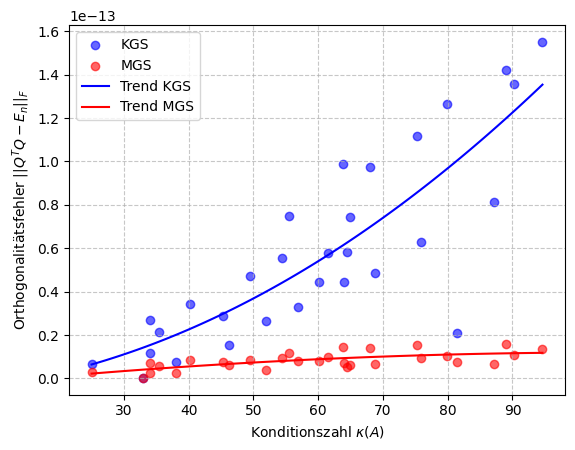

In [ ]:
def decomp_err_by_cond(sample_size):
    errs_kgs = []
    errs_mgs = []

    for x in range(sample_size):
        n = np.random.randint(2,50)
        cond = np.random.uniform(1,100)
        A, eig = generate_test_matrix(n, cond)

        kgs_Q, kgs_R = QR_via_KGS(A)
        mgs_Q, mgs_R = QR_via_MGS(A)

        err_orth_kgs = np.linalg.norm(kgs_Q.T @ kgs_Q - np.eye(n), ord='fro')
        err_orth_mgs = np.linalg.norm(mgs_Q.T @ mgs_Q - np.eye(n), ord='fro')

        errs_kgs.append((cond, err_orth_kgs))
        errs_mgs.append((cond, err_orth_mgs))

    return errs_kgs, errs_mgs

def graph_decomp_by_cond(errs_kgs, errs_mgs):
    x_kgs, y_kgs = zip(*errs_kgs)
    x_mgs, y_mgs = zip(*errs_mgs)

    plt.scatter(x_kgs, y_kgs, color='blue', label='KGS', alpha=0.6)
    plt.scatter(x_mgs, y_mgs, color='red', label='MGS', alpha=0.6)

    #Durchschnitts linie
    zeichne_trendlinie(x_kgs, y_kgs, 'blue', 'KGS')
    zeichne_trendlinie(x_mgs, y_mgs, 'red', 'MGS')

    #Beschriftungen/Legende
    plt.xlabel(r'Konditionszahl $\kappa(A)$')
    plt.ylabel(r'Orthogonalitätsfehler $||Q^T Q - E_n||_F$')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.savefig('plot_kgs_vs_mgs_orthogonalizarion_error.pdf', bbox_inches='tight')
    plt.show()

a,b = decomp_err_by_cond(30)
graph_decomp_by_cond(a,b)

QR-Konvergenz

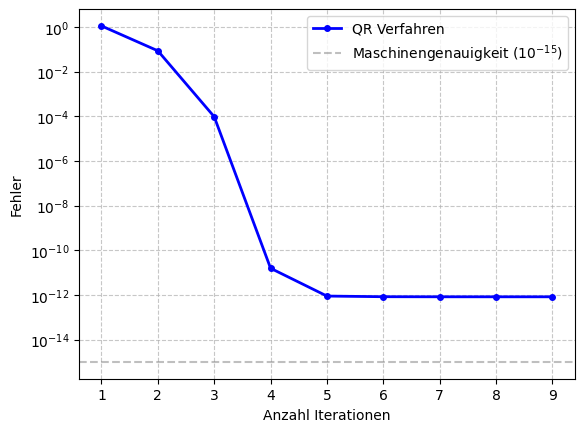

In [ ]:
def QR_convergence(sample_size=10):
    steps = np.arange(1, 10)

    median_errors = []

    # Wir generieren feste Testmatrizen
    test_set = []
    for _ in range(sample_size):
        A, _ = generate_tridiag_matrix(50, cond=100) #(dim=50, cond=100)
        true_evals = np.sort(np.linalg.eigvals(A))
        test_set.append((A, true_evals))

    for step in steps:
        current_errors = []
        for A, true_evals in test_set:
            # Algorithmus zwingen, nach 'step' Iterationen abzubrechen
            calc_evals = qr_algorithm_deflation(A.copy(), eps=1e-14, max_iter=step, qr_function=np.linalg.qr)
            calc_evals = np.sort(calc_evals)

            err = np.linalg.norm(calc_evals - true_evals)
            current_errors.append(err)

        # Median speichern (besser bei Ausreißern)
        median_errors.append(np.median(current_errors))

    return steps, median_errors

def plot_QR_convergence(steps, errors):
    # Semilogy: Nur Y ist logarithmisch. X ist linear (Schritt 1, 2, 3...)
    plt.semilogy(steps, errors, 'b-o', linewidth=2, markersize=4, label='QR Verfahren')

    # Hilfslinie für Maschinengenauigkeit
    plt.axhline(y=1e-15, color='gray', linestyle='--', alpha=0.5, label='Maschinengenauigkeit ($10^{-15}$)')

    plt.xlabel('Anzahl Iterationen')
    plt.ylabel('Fehler')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.savefig('plot_QR_convergence_rate.pdf', bbox_inches='tight')
    plt.show()

# Ausführen
x_steps, y_errors = QR_convergence(sample_size=1000)
plot_QR_convergence(x_steps, y_errors)

Fehrer der eigenwertberechnung unter verwendung verschiedener Zerlegungen oder Divide and Conquer in abhängigkeit der Konditionszahl

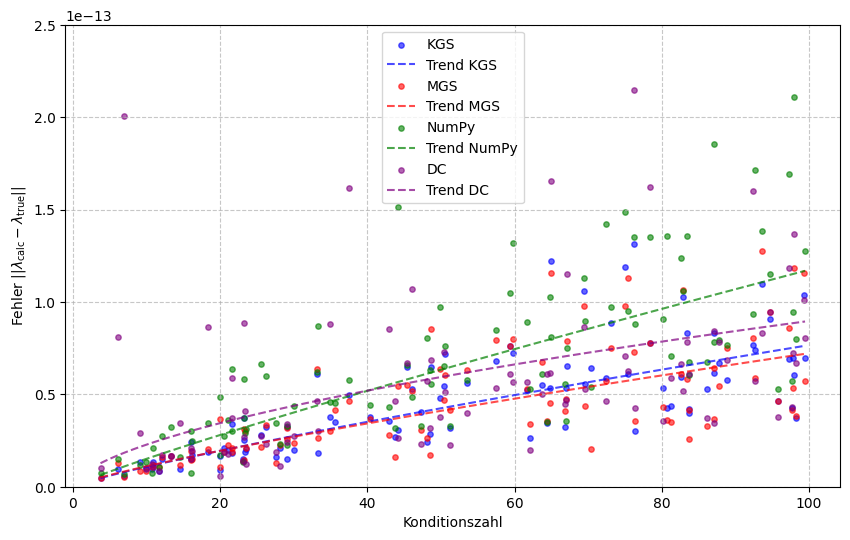

In [ ]:
def compare_all_algorithms(sample_size):
    results = {'KGS': [], 'MGS': [], 'NumPy': [], 'DC': []}

    for i in range(sample_size):
        n = np.random.randint(10, 30) # Nicht zu groß, D&C ist rekursiv

        # Kondition auf einen sehr kleinen, linearen Bereich setzen
        cond = np.random.uniform(1, 100) # Max Konditionszahl auf 100 reduziert

        # Normalen Tridiagonal-Generator nutzen
        A, evals_true = generate_tridiag_matrix(n, cond)

        # --- 1. KGS ---
        try:
            # max_iter begrenzen, damit es nicht ewig läuft
            evals_kgs = np.sort(qr_algorithm_deflation(A.copy(), qr_function=QR_via_KGS, max_iter=1000))
            err_kgs = np.linalg.norm(evals_kgs - evals_true)
        except:
            err_kgs = np.nan
        results['KGS'].append((cond, err_kgs))

        # --- 2. MGS ---
        try:
            evals_mgs = np.sort(qr_algorithm_deflation(A.copy(), qr_function=QR_via_MGS, max_iter=1000))
            err_mgs = np.linalg.norm(evals_mgs - evals_true)
        except:
             err_mgs = np.nan
        results['MGS'].append((cond, err_mgs))

        # --- 3. NumPy QR ---
        evals_np = np.sort(qr_algorithm_deflation(A.copy(), qr_function=np.linalg.qr, max_iter=1000))
        err_np = np.linalg.norm(evals_np - evals_true)
        results['NumPy'].append((cond, err_np))

        # --- 4. Divide & Conquer ---
        # Achtung: D&C gibt (vecs, vals) zurück, wir brauchen nur vals [1]
        try:
            _, evals_dc = divide_and_conquer(A.copy())
            evals_dc = np.sort(evals_dc)
            err_dc = np.linalg.norm(evals_dc - evals_true)
        except Exception as e:
            # Falls D&C crasht (sollte nicht passieren, aber sicher ist sicher)
            err_dc = np.nan
        results['DC'].append((cond, err_dc))

    return results

def plot_comparison(results):
    plt.figure(figsize=(10, 6))

    colors = {'KGS': 'blue', 'MGS': 'red', 'NumPy': 'green', 'DC': 'purple'}

    for name, data in results.items():
        # Filtern von NaN-Werten für die Darstellung und Trendlinie
        x_data = [item[0] for item in data if not np.isnan(item[1])]
        y_data = [item[1] for item in data if not np.isnan(item[1])]

        plt.scatter(x_data, y_data, color=colors[name], label=name, alpha=0.6, s=15)

        # Jetzt die logarithmische Trendlinie verwenden, auch wenn Achsen linear sind
        if len(x_data) > 1: # Sicherstellen, dass genügend Datenpunkte vorhanden sind
            zeichne_trendlinie_loglog(x_data, y_data, colors[name], name)

    # Log-Skalen entfernen (sind bereits entfernt)
    # plt.xscale('log')
    # plt.yscale('log')
    plt.xlabel('Konditionszahl')
    plt.ylabel(r'Fehler $||λ_{\text{calc}} - λ_{\text{true}}||$')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    # Hinzufügen einer Y-Achsenbegrenzung, um Ausreißer zu "schneiden"
    plt.ylim(top=0.25e-12, bottom = 0) # Angepasste obere Grenze basierend auf maximalen Fehlern

    plt.savefig('plot_eigval_error_by_alg_and_cond.pdf', bbox_inches='tight')
    plt.show()

# Ausführen
res = compare_all_algorithms(100) # Stichprobengröße auf 100 erhöht
plot_comparison(res)

Rechenzeit vs Dimension


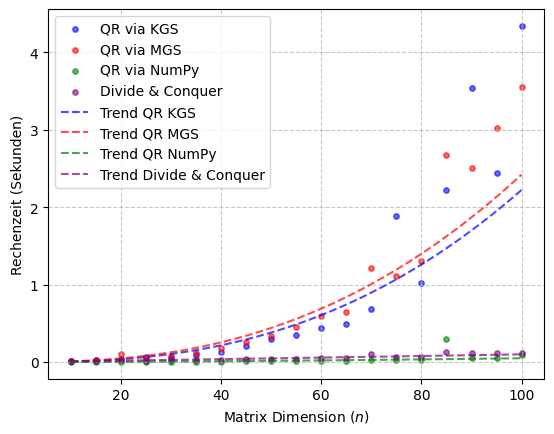

In [ ]:
import time
def trendlinie_log(x_data, y_data, color, label_text):
    """
    Zeichnet eine lineare Trendlinie in einen Log-Log-Plot.
    Mathematisch: Fittet y = a * x^b (erscheint als Gerade im Log-Log).
    """
    # 1. Sicherstellen, dass es Numpy Arrays sind
    x = np.array(x_data)
    y = np.array(y_data)

    # 2. Maskierung: Wir können nur positive Werte logarithmieren.
    # Wir filtern Nullen, NaNs und unendlich kleine Werte (Rauschen) heraus.
    mask = (x > 0) & (y > 1e-20) & (np.isfinite(y))

    x_clean = x[mask]
    y_clean = y[mask]

    # Abbruch, falls zu wenige gültige Punkte für eine Linie da sind
    if len(x_clean) < 2:
        return

    # 3. Lineare Regression auf den LOGARITHMEN (Basis 10)
    # Wir suchen m und c für: log(y) = m * log(x) + c
    coeffs = np.polyfit(np.log10(x_clean), np.log10(y_clean), 1)
    poly_func = np.poly1d(coeffs)

    # 4. Linie generieren
    # geomspace erzeugt Punkte, die im Log-Plot gleichmäßig verteilt sind
    x_line = np.geomspace(min(x_clean), max(x_clean), 100)

    # Y-Werte berechnen und zurücktransformieren (10 hoch ...)
    y_line_log = poly_func(np.log10(x_line))
    y_line = 10**y_line_log

    # 5. Plotten (Gestrichelt)
    plt.plot(x_line, y_line, color=color, linestyle='--', linewidth=2, label=f'Trend {label_text}')

kgs_results = []
mgs_results = []
np_qr_results = []
dc_results = []

dimensions_to_test = np.arange(10, 101, 5)

fixed_condition_number = 50

for n in dimensions_to_test:
    A, true_evals = generate_tridiag_matrix(n, cond=fixed_condition_number)
    true_evals = np.sort(np.real(true_evals))

    # --- KGS QR ---
    A_copy_kgs = A.copy()
    start_time_kgs = time.time()
    try:
        # Limiting max_iter to prevent extremely long runs for potentially unstable KGS
        calculated_evals_kgs = qr_algorithm_deflation(A_copy_kgs, qr_function=QR_via_KGS, max_iter=500)
        calculated_evals_kgs = np.sort(np.real(calculated_evals_kgs))
        error_kgs = np.linalg.norm(calculated_evals_kgs - true_evals)
        time_kgs = time.time() - start_time_kgs
    except Exception as e:
        error_kgs = np.nan # Mark as NaN if it fails
        time_kgs = np.nan
        print(f"KGS failed for n={n}: {e}")
    kgs_results.append((n, error_kgs, time_kgs))

    # --- MGS QR ---
    A_copy_mgs = A.copy()
    start_time_mgs = time.time()
    try:
        calculated_evals_mgs = qr_algorithm_deflation(A_copy_mgs, qr_function=QR_via_MGS, max_iter=500)
        calculated_evals_mgs = np.sort(np.real(calculated_evals_mgs))
        error_mgs = np.linalg.norm(calculated_evals_mgs - true_evals)
        time_mgs = time.time() - start_time_mgs
    except Exception as e:
        error_mgs = np.nan
        time_mgs = np.nan
        print(f"MGS failed for n={n}: {e}")
    mgs_results.append((n, error_mgs, time_mgs))

    # --- NumPy QR ---
    A_copy_np = A.copy()
    start_time_np = time.time()
    try:
        calculated_evals_np = qr_algorithm_deflation(A_copy_np, qr_function=np.linalg.qr, max_iter=500)
        calculated_evals_np = np.sort(np.real(calculated_evals_np))
        error_np = np.linalg.norm(calculated_evals_np - true_evals)
        time_np = time.time() - start_time_np
    except Exception as e:
        error_np = np.nan
        time_np = np.nan
        print(f"NumPy QR failed for n={n}: {e}")
    np_qr_results.append((n, error_np, time_np))

    # --- Divide & Conquer ---
    A_copy_dc = A.copy()
    start_time_dc = time.time()
    try:
        _, calculated_evals_dc = divide_and_conquer(A_copy_dc)
        calculated_evals_dc = np.sort(np.real(calculated_evals_dc))
        error_dc = np.linalg.norm(calculated_evals_dc - true_evals)
        time_dc = time.time() - start_time_dc
    except Exception as e:
        error_dc = np.nan
        time_dc = np.nan
        print(f"Divide & Conquer failed for n={n}: {e}")
    dc_results.append((n, error_dc, time_dc))

x_kgs_time, _, y_kgs_time = zip(*[(d, e, t) for d, e, t in kgs_results if not np.isnan(t)])
x_mgs_time, _, y_mgs_time = zip(*[(d, e, t) for d, e, t in mgs_results if not np.isnan(t)])
x_np_time, _, y_np_time = zip(*[(d, e, t) for d, e, t in np_qr_results if not np.isnan(t)])
x_dc_time, _, y_dc_time = zip(*[(d, e, t) for d, e, t in dc_results if not np.isnan(t)])

plt.scatter(x_kgs_time, y_kgs_time, color='blue', label='QR via KGS', alpha=0.6, s=15)
plt.scatter(x_mgs_time, y_mgs_time, color='red', label='QR via MGS', alpha=0.6, s=15)
plt.scatter(x_np_time, y_np_time, color='green', label='QR via NumPy', alpha=0.6, s=15)
plt.scatter(x_dc_time, y_dc_time, color='purple', label='Divide & Conquer', alpha=0.6, s=15)

zeichne_trendlinie_loglog(x_kgs_time, y_kgs_time, 'blue', 'QR KGS')
zeichne_trendlinie_loglog(x_mgs_time, y_mgs_time, 'red', 'QR MGS')
zeichne_trendlinie_loglog(x_np_time, y_np_time, 'green', 'QR NumPy')
zeichne_trendlinie_loglog(x_dc_time, y_dc_time, 'purple', 'Divide & Conquer')

plt.xlabel(r'Matrix Dimension ($n$)')
plt.ylabel('Rechenzeit (Sekunden)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('plot_alg_calculation_time_vs_dimension.pdf', bbox_inches='tight')
# plt.tight_layout()
plt.show()